# Preparing Data

In [1]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/using_parameters_instead/data/16APR2025.h5ad")
folder_to_group_mapping = adata.obs[["folder", "group"]].drop_duplicates().set_index("folder")["group"].to_dict()

adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])
adata.obs["log_plin2_area"] = np.log1p(adata.obs["plin2_area"])
adata.obs["log_oil_red_o_area"] = np.log1p(adata.obs["oil_red_o_area"])
adata.obs["lipid_droplet"] = adata.obs["log_lipid_droplet_area"].gt(0).astype(int)
adata.obs["near_amyloid"] = adata.obs["distance_to_nearest_amyloid"].lt(60).astype(int)

/home/jhaberbe/Projects/Personal/using_parameters_instead/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
adata.obs.query("cell_type == 'Microglia-PVM'").groupby(["near_amyloid"])["lipid_droplet"].value_counts().unstack()

lipid_droplet,0,1
near_amyloid,,
0,31879,8446
1,1390,682


# Loading Modules

In [3]:
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")
from src.using_parameters_instead import formula, model, summary, statistics, plotting

importlib.reload(formula)
importlib.reload(model)
importlib.reload(summary)
importlib.reload(statistics)
importlib.reload(plotting)

<module 'src.using_parameters_instead.plotting' from '/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/plotting.py'>

# Differential Expression
Differential expression is done using a negative binomial model. The general structure is:

`expression ~ size_factor + folder + folder:lipid_droplet + folder:near_amyloid`

I've decided to do blocking between grey matter and white matter, because there may be differences in the way each of the variables scale between grey and white matter, and I would like to avoid very long interaction terms
- `folder:lipid_droplet:spatial_groups_2960` is pretty annoying to interpret.

In [7]:
import os
import pickle

output_folder = "/home/jhaberbe/Projects/Personal/using_parameters_instead/output/test"
try:
    os.mkdir(output_folder)
except:
    print("already exists")

already exists


In [5]:
for cell_type in adata.obs["cell_type"].unique():
    pass
    # We subset by cell type, and return grey vs white matter. 
    subset = adata[adata.obs["cell_type"].eq(cell_type) & adata.obs["spatial_groups_2960"].eq("Grey")]

    subset.obs["transcript_counts_red"] = np.log(subset.layers["transcript"].sum(axis=1) / subset.layers["transcript"].sum(axis=1).mean())

    design_matrix_factory = formula.DesignMatrixFactory(
        "folder", 
        ["lipid_droplet", "near_amyloid"],
        intercept = False
    )

    differential_expression_testing = model.DifferentialExpressionTesting(
        model.NegativeBinomialModelFitter(),
        design_matrix_factory
    )

    results = differential_expression_testing.fit_model_over_features(
        adata=subset, 
        layer="transcript",
        min_expression=0.05,
        reset=False,
        offset=subset.obs["transcript_counts_red"]
    )

    pickle.dump(results, open(f"{output_folder}/{cell_type.replace('/', '-')}.pickle", "wb"))


100%|██████████| 366/366 [01:41<00:00,  3.61it/s]

In [8]:
results

{'ABCC9': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cd297f0>,
 'ACAT1': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cc6c550>,
 'ACAT2': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cc6ca50>,
 'ACSL1': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cd650f0>,
 'ACSL3': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cd655b0>,
 'ACSL4': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cd02f90>,
 'ACSL5': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cc59480>,
 'ADRA1A': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cc598c0>,
 'AIF1': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cfbb550>,
 'ANO3': <statsmodels.discrete.discrete_model.NegativeBinomialResultsWrapper at 0x71250cfb9950>,
 'ANXA1': <statsmodel

# Statistical Testing

Statistical tests here are performed using a t-test on the parameter estimates that we derive from the model between biological replicates. I found this is the most robust way to do differential expression. I've created some utlities to get the dataframes from the fitted model, but i'm saving the entire fitted model to pickle'd files, since there is a lot of information I might like to retrieve at some point.

In [12]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
# Can change to near_amyloid, remove the covariate argument to just get each folder's intercept, which can be used to do differential expression between diagnostic groups.
summarizer.summary_dataframe(results, covariate="lipid_droplet")

/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


,ABCC9,ACAT1,ACAT2,ACSL1,ACSL3,ACSL4,ACSL5,ADRA1A,AIF1,ANO3,...,TRHDE,TRIL,TSHZ2,TTYH1,UGT8,UNC5B,VCAN,WIF1,specimen,interaction_term
index,,,,,,,,,,,,,,,,,,,,,
folder[04-06]:lipid_droplet,0.265513,0.165226,0.162690,-0.028916,0.201775,0.111668,0.099691,0.093353,-0.130977,0.551257,...,-0.120026,0.231692,-0.064543,0.073531,0.143352,0.110060,0.252282,0.406741,04-06,lipid_droplet
folder[14-20]:lipid_droplet,0.111865,-0.024510,-0.150183,-0.100674,0.169256,-0.052755,-0.031384,-0.001605,-0.113636,0.325814,...,0.083022,0.384379,0.407965,0.323195,0.364754,0.027273,-0.306771,0.638055,14-20,lipid_droplet
folder[13-54]:lipid_droplet,-0.321347,-0.037928,0.109851,-0.292659,0.029434,0.086695,0.014091,-0.107854,-0.246224,0.460797,...,0.464001,0.132633,0.609107,0.034743,0.222376,0.109100,0.183588,0.024353,13-54,lipid_droplet
folder[05-27]:lipid_droplet,0.319974,0.026023,-0.238376,-0.146321,0.041402,-0.008620,0.050190,0.334528,-0.087924,0.297049,...,0.399132,0.084159,-0.120740,0.064585,0.255652,0.106973,0.034989,-0.222501,05-27,lipid_droplet
folder[15-27]:lipid_droplet,0.107563,-0.004906,0.203269,-0.073449,0.125495,0.005607,-0.056433,-0.030630,-0.077481,0.666890,...,0.292145,0.327624,-0.036821,0.303327,0.399948,0.194607,0.177086,0.333653,15-27,lipid_droplet
folder[99-15]:lipid_droplet,0.161496,0.214054,-0.012311,0.107433,0.088094,-0.072135,-0.097918,-0.078076,-0.211150,0.278170,...,0.072528,0.306474,0.603747,0.190901,-0.063584,0.127615,-0.220380,0.148029,99-15,lipid_droplet
folder[18-20]:lipid_droplet,-0.025506,0.252767,0.119979,-0.106153,0.254610,0.132686,-0.169689,0.154397,-0.092539,0.508315,...,0.034974,0.127759,0.147217,0.141218,0.317563,-0.106619,0.087849,0.263935,18-20,lipid_droplet
folder[18-75]:lipid_droplet,0.054420,0.119803,0.098128,-0.037206,0.192713,0.331206,-0.241164,0.194870,-0.084541,0.378521,...,0.189108,0.189086,0.465334,0.217830,0.399035,0.196882,0.879069,0.353784,18-75,lipid_droplet
folder[10-46]:lipid_droplet,0.426379,-0.418398,0.119580,-0.099438,0.003523,-0.131952,0.048803,0.052292,-0.010178,0.317786,...,0.267047,0.652623,0.298272,0.582521,0.737703,-0.146881,0.405032,-0.083154,10-46,lipid_droplet


#### Global Effect
What is the effect on all cells for lipid droplet (or amyloid) accumulation, irrespective of cognitive diagnosis. (One way t-test vs mean of 0)

/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


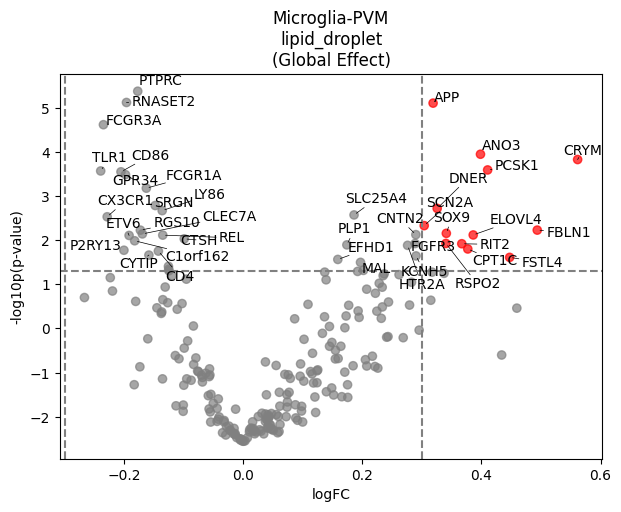

In [14]:
import scipy.stats

def global_effect_plot(results, output_location, design_matrix_factory=design_matrix_factory, covariate = "lipid_droplet"):
    summarizer = summary.ModelResultSummarizer(design_matrix_factory)
    df = summarizer.summary_dataframe(results, covariate=covariate)
    df = df.drop(["specimen", "interaction_term"], axis=1)

    table = pd.DataFrame({
        feature: {
            "statistic": test_result.statistic,
            "pvalue": test_result.pvalue * 366,
            "logFC": df[feature].mean(),
            "std": df[feature].std(),
        }
        for feature, test_result in {feature: scipy.stats.ttest_1samp(df[feature], 0) for feature in df.columns}.items()
    }).T.eval("log10p = -log10(pvalue)").rename(columns=dict(log10p = "-log10p"))

    plotting.volcano_plot(table, .3, top_n_genes=40)

    plt.title(f"{cell_type}\n{covariate}\n(Global Effect)")
    plt.savefig(output_location)

# for cell_type in adata.obs["cell_type"].unique():
results = pickle.load(open(f"{output_folder}/{cell_type.replace('/', '-')}.pickle", "rb"))
global_effect_plot(results, output_location=f"{output_folder}/{cell_type}.svg")

#### Group Level Differences
Differences between each group, 

/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \
/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \
/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: Set

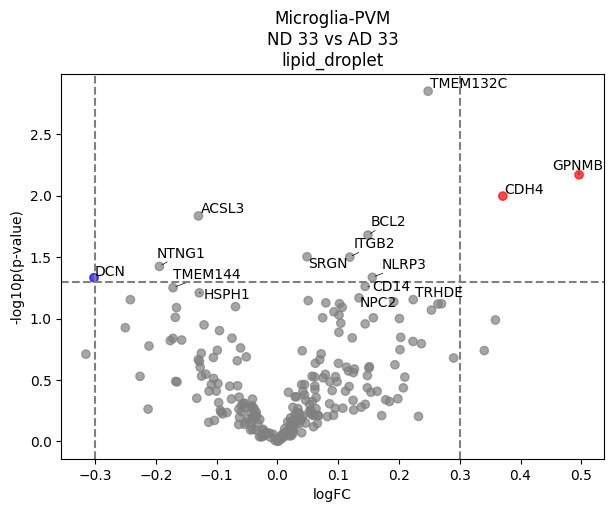

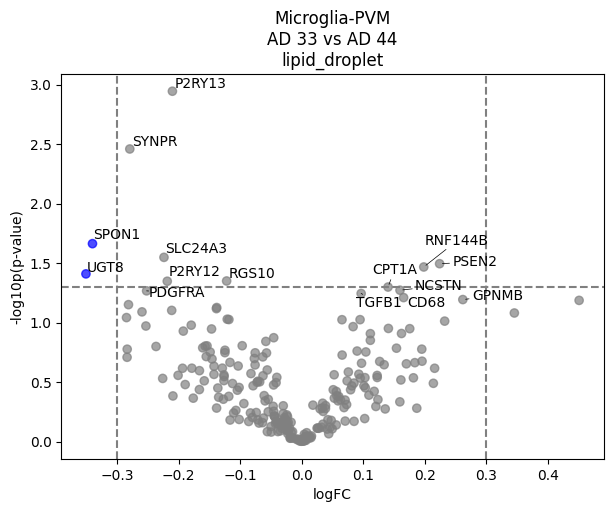

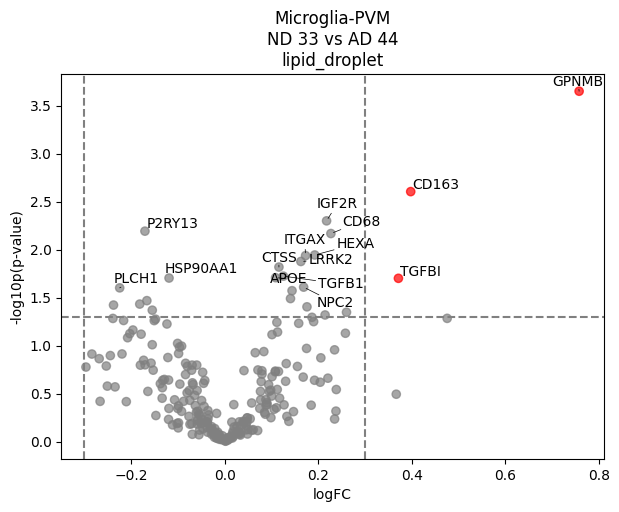

In [ ]:
def group_level_differences(results, output_location, covariate="lipid_droplet", design_matrix_factory=design_matrix_factory, g1="ND 33", g2="AD 33"):
    summarizer = summary.ModelResultSummarizer(design_matrix_factory)
    df = summarizer.summary_dataframe(results, covariate=covariate)
    df["group"] = df["specimen"].replace(folder_to_group_mapping)
    table = pd.DataFrame({
        feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict(g1, g2, feature, equal_var=False)
        for feature in adata.var_names.intersection(df.columns)
    }).T
    ad_33 = table["logFC"]
    plotting.volcano_plot(table.query("abs(logFC) < 2"), .3)
    plt.title(f"{cell_type}\n{g1} vs {g2}\n{covariate}")
    plt.savefig(f"{output_location}/{cell_type.replace('/', '-')}_{g1}_{g2}.svg")

for cell_type in adata.obs["cell_type"].unique():
    results = pickle.load(open(f"{output_folder}/{cell_type.replace('/', '-')}.pickle", "rb"))
    group_level_differences(results, output_location=f"{output_folder}")
    group_level_differences(results, output_location=f"{output_folder}", g1="AD 33", g2="AD 44")
    group_level_differences(results, output_location=f"{output_folder}", g1="ND 33", g2="AD 44")

#### Group level differences

/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


<Axes: xlabel='group', ylabel='GPNMB'>

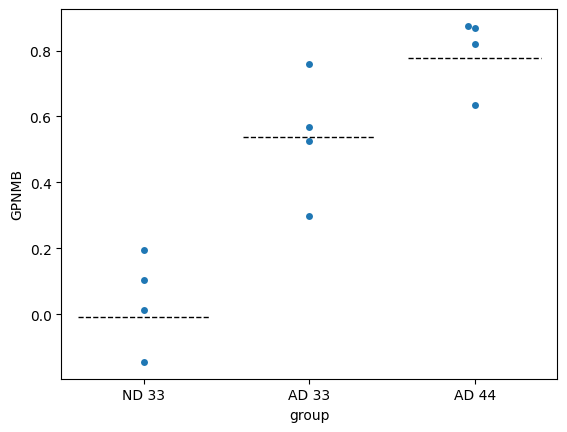

In [17]:
import seaborn as sns

gene = "GPNMB"

summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="lipid_droplet")
df["group"] = df["specimen"].replace(folder_to_group_mapping)

sns.swarmplot(df, x="group", y=gene, order=["ND 33", "AD 33", "AD 44"])
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': 'dashed', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="group",
            y=gene,
            data=df.iloc[:-2],
            showfliers=False,
            showbox=False,
            showcaps=False)

#### One way t-test

<Axes: ylabel='PLIN2'>

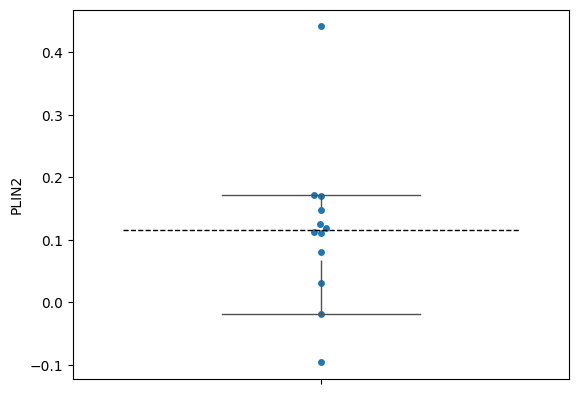

In [19]:
import seaborn as sns
gene = "PLIN2"

sns.swarmplot(df, y=gene)
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': 'dashed', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': True},
            zorder=10,
            y=gene,
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=True)